Team Members:


1.   Krishna Sharma S - mcs24006
2.   Vaibhav Agrawal - mcs24007
3.   Naweed Aquib - mcs24009



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ckay16/accident-detection-from-cctv-footage")

print("Path to dataset files:", path)

100%|██████████| 249M/249M [00:03<00:00, 71.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1


In [ ]:
import zipfile
import os

# Path to the downloaded dataset
dataset_path = path  # This is the path returned by kagglehub.dataset_download

# Extract the dataset if it's a ZIP file
if dataset_path.endswith('.zip'):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall("extracted_dataset")
    print("Dataset extracted to 'extracted_dataset' folder.")
    extracted_path = "extracted_dataset"
else:
    extracted_path = dataset_path

# List files in the extracted dataset
print("Files in the dataset:")
for root, dirs, files in os.walk(extracted_path):
    for file in files:
        print(os.path.join(root, file))

Files in the dataset:
/root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1/data/val/Accident/test14_19.jpg
/root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1/data/val/Accident/test_26.jpg
/root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1/data/val/Accident/test10_23.jpg
/root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1/data/val/Accident/test27_21.jpg
/root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1/data/val/Accident/test18_25.jpg
/root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1/data/val/Accident/test10_54.jpg
/root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1/data/val/Accident/acc1 (4).jpg
/root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1/data/val/Accident/test21_22.jpg
/root/.cache/kagglehub/datase

In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1/data"

for split in ["train", "test", "val"]:
    acc_count = len(os.listdir(f"{dataset_path}/{split}/Accident"))
    non_acc_count = len(os.listdir(f"{dataset_path}/{split}/Non Accident"))
    print(f"{split}: Accident = {acc_count}, Non-Accident = {non_acc_count}")

train: Accident = 369, Non-Accident = 422
test: Accident = 47, Non-Accident = 54
val: Accident = 46, Non-Accident = 52


Preview some images

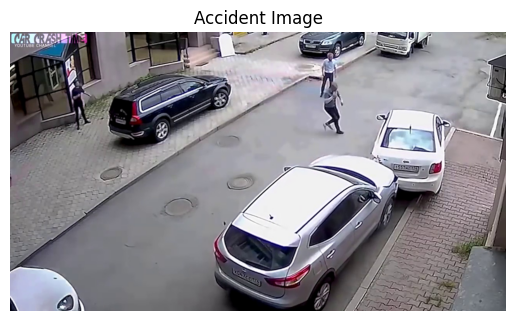

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_path = f"{dataset_path}/train/Accident/test30_17.jpg"  # Change to any image path
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.title("Accident Image")
plt.show()

## Preprocess the dataset

In [ ]:
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Define paths
dataset_path = "/root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1/data"
output_path = "/content/preprocessed_dataset"
os.makedirs(output_path, exist_ok=True)

In [ ]:
# Image processing and augmentation pipeline
transform = A.Compose([
    A.Resize(224, 224),  # Resize images
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),  # Reduce noise using Gaussian Blur
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),  # Enhance contrast using CLAHE
    A.HorizontalFlip(p=0.5),  # Random horizontal flip
    A.RandomBrightnessContrast(p=0.3),  # Adjust brightness & contrast to change lighting
    A.MotionBlur(blur_limit=5, p=0.2),  # Simulate motion blur
    A.ISONoise(p=0.2),  # Add noise
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Function to process and save images
def process_images(split):
    for category in ["Accident", "Non Accident"]:
        input_folder = os.path.join(dataset_path, split, category)
        output_folder = os.path.join(output_path, split, category)
        os.makedirs(output_folder, exist_ok=True)

        for img_name in tqdm(os.listdir(input_folder), desc=f"Processing {split}/{category}"):
            img_path = os.path.join(input_folder, img_name)

            if not os.path.exists(img_path):
                print(f"Skipping {img_path}, file not found.")
                continue

            img = cv2.imread(img_path)
            if img is None:
                print(f"Skipping {img_path}, unreadable image.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            augmented = transform(image=img)['image']

            # Convert back to NumPy and undo normalization before saving
            augmented = augmented.permute(1, 2, 0).numpy()  # Convert tensor to NumPy (H, W, C)

            # Undo normalization: multiply by std, add mean, and rescale to 0-255
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            augmented = (augmented * std + mean) * 255  # Undo normalization
            augmented = np.clip(augmented, 0, 255).astype(np.uint8)  # Ensure valid range

            # Define save path
            save_path = os.path.join(output_folder, img_name)

            # Convert RGB back to BGR before saving
            cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))


In [ ]:
# Process train, test, val sets
for split in ["train", "val", "test"]:
    process_images(split)

print("Preprocessing and augmentation completed! Processed images saved in:", output_path)

Processing test/Non Accident: 100%|██████████| 54/54 [00:00<00:00, 92.96it/s]

Skipping /root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1/data/test/Non Accident/Pictures - Shortcut.lnk, unreadable image.
Preprocessing and augmentation completed! Processed images saved in: /content/preprocessed_dataset


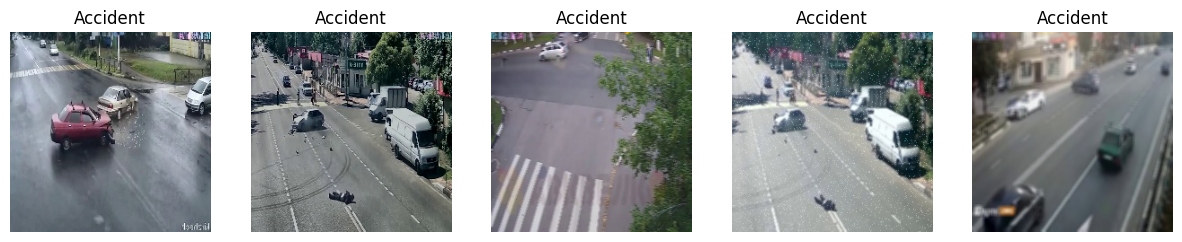

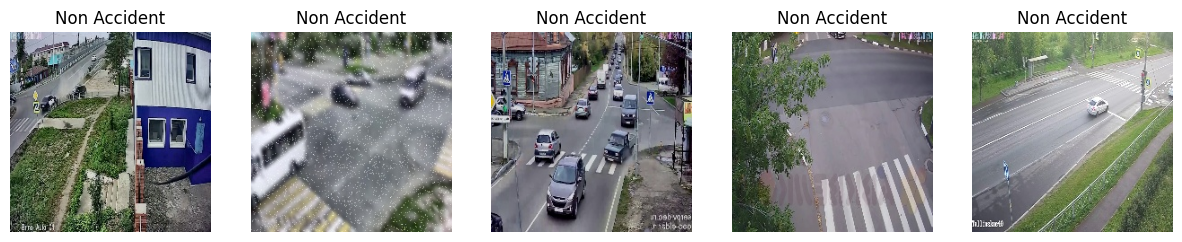

In [ ]:
import matplotlib.pyplot as plt
import random

# Function to display images
def show_images(folder, class_name, num_images=5):
    class_path = os.path.join("/content/preprocessed_dataset/train", class_name)
    images = os.listdir(class_path)

    if len(images) == 0:
        print(f"No images found in {class_path}")
        return

    selected_images = random.sample(images, min(num_images, len(images)))

    fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(class_name)

    plt.show()

# Show images from both classes
show_images("/content/preprocessed_dataset/train", "Accident")
show_images("/content/preprocessed_dataset/train", "Non Accident")


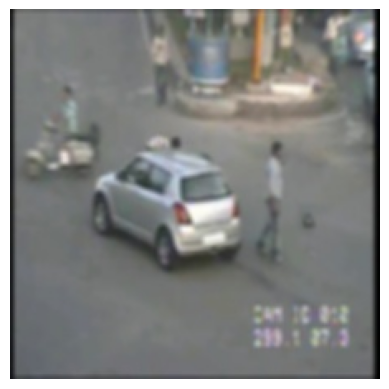

In [ ]:
import matplotlib.pyplot as plt

# Load a sample preprocessed image
sample_img_path = "/content/preprocessed_dataset/train/Accident/acc1 (14).jpg"  # Change to an actual image path

img = cv2.imread(sample_img_path)  # OpenCV loads in BGR format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display

plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the preprocessed dataset to drive
!cp -r /content/preprocessed_dataset /content/drive/MyDrive/

In [ ]:
# Verify save loc
!ls /content/drive/MyDrive/preprocessed_dataset

test  train  val


# Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit ResNet input
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

# Define dataset paths
data_dir = "/content/preprocessed_dataset"

# Load train, validation, and test datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['Accident', 'Non Accident']


In [ ]:
# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Modify the final layer for 2-class classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 output classes (Accident, Non-Accident)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)  # Get predicted class indices
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

    # Step the scheduler
    scheduler.step()

Epoch 1/10, Loss: 0.5715, Train Acc: 69.28%
Epoch 2/10, Loss: 0.1823, Train Acc: 93.17%
Epoch 3/10, Loss: 0.1226, Train Acc: 95.70%
Epoch 4/10, Loss: 0.0546, Train Acc: 98.61%
Epoch 5/10, Loss: 0.0370, Train Acc: 99.12%
Epoch 6/10, Loss: 0.0236, Train Acc: 99.49%
Epoch 7/10, Loss: 0.0240, Train Acc: 99.62%
Epoch 8/10, Loss: 0.0200, Train Acc: 99.75%
Epoch 9/10, Loss: 0.0236, Train Acc: 99.62%
Epoch 10/10, Loss: 0.0172, Train Acc: 99.62%


### Model Evaluation

In [ ]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 94.00%


Precision: 0.91, Recall: 0.98, F1 Score: 0.95


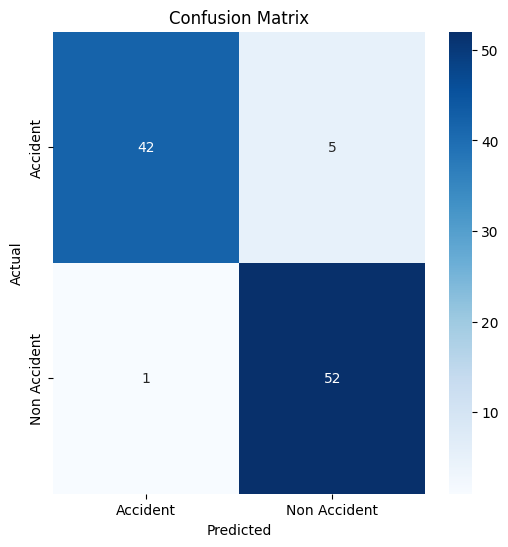

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Store true labels and predictions
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute Precision, Recall, F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Save the model

In [ ]:
# Save the model
torch.save(model.state_dict(), "/content/accident_detection_model.pth")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
model_save_path = '/content/drive/My Drive/preprocessed_dataset/model/accident_detection_model.pth'

# Save the model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved successfully to {model_save_path}")

Model saved successfully to /content/drive/My Drive/preprocessed_dataset/model/accident_detection_model.pth
